In [1]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange
import os
from torchvision.datasets import ImageFolder
import tarfile

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(160),               # resize to 160×160 for imagenette2-160
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
# Paths for the Imagenette dataset (assumes you want it under ./data/imagenette2-160/)
imagenette_root = "./data/imagenette2-160"
train_dir = os.path.join(imagenette_root, "train")
val_dir   = os.path.join(imagenette_root, "val")

# download & extract if not already present
if not os.path.isdir(imagenette_root):
    os.makedirs(os.path.dirname(imagenette_root), exist_ok=True)
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    archive_path = os.path.join(os.path.dirname(imagenette_root), "imagenette2-160.tgz")
    if not os.path.exists(archive_path):
        print("Downloading Imagenette dataset...")
        import urllib.request
        urllib.request.urlretrieve(url, archive_path)
    print("Extracting Imagenette dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(imagenette_root))
    print("Done.")

# Load the Imagenette dataset
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset  = ImageFolder(val_dir,   transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1024, shuffle=False)

In [2]:
resnet_pretrained = models.resnet152(pretrained=True)

# replace the final classification layer with identity to get 512‑dim embeddings
resnet_pretrained.fc = torch.nn.Identity()
# move to device and set to eval mode
resnet_pretrained = resnet_pretrained.to('cuda')
resnet_pretrained.eval()
print("loaded")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded


In [3]:
embeddings = []

for images, labels in tqdm(test_loader):
    # Forward pass through the model
    with torch.no_grad():        
        features = resnet_pretrained(images.cuda())
        embeddings.append(features)

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
embeddings = torch.cat(embeddings, dim=0)
normed_embeddings = torch.nn.functional.normalize(embeddings, dim=1)

kernel_matrix = normed_embeddings @ normed_embeddings.T
print(kernel_matrix.shape)

torch.Size([3925, 3925])


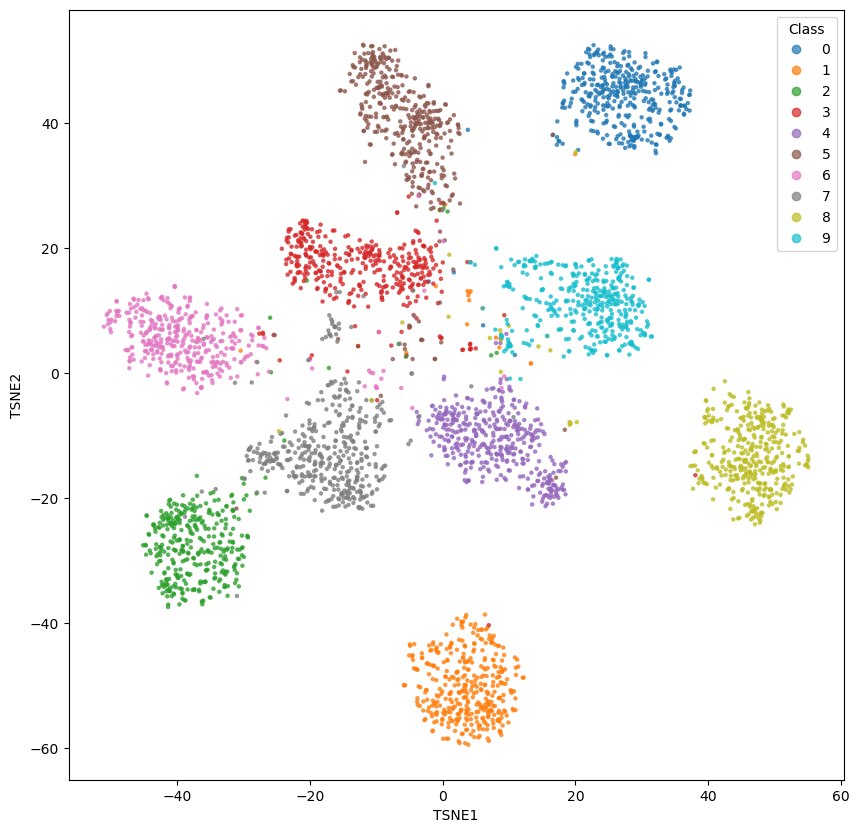

In [5]:
from sklearn.manifold import TSNE

# move embeddings to CPU numpy
emb_np = embeddings.cpu().numpy()

# compute 2D tsne
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

# get true labels from test_dataset
labels = np.array(test_dataset.targets)

# plot
plt.figure(figsize=(10, 10))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                 c=labels, cmap='tab10', s=5, alpha=0.7)
plt.legend(*sc.legend_elements(), title="Class", loc="best")
#plt.title("Original Imagenette Labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Save the figure to a file
plt.savefig('imagenette_labels_tsne.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [6]:
# low‑rank approximation of the kernel matrix K ≈ B B^T
r = 256
#remove diagonal elements in kernel matrix: 
#kernel_matrix = kernel_matrix - torch.diag(torch.diag(kernel_matrix))
U, S, _ = torch.linalg.svd(kernel_matrix)
B = (U[:, :r] * torch.sqrt(S[:r])).cpu().numpy()
#approx error
errors = kernel_matrix.cpu().numpy() - B @ B.T
print("approx error", np.linalg.norm(errors, ord='fro'))

approx error 4.5068455


Fraction in class 0: 0.1245859872611465
Fraction in class 1: 0.09222929936305732
Fraction in class 2: 0.07872611464968153
Fraction in class 3: 0.10089171974522293
Fraction in class 4: 0.0007643312101910828
Fraction in class 5: 0.15159235668789808
Fraction in class 6: 0.22318471337579618
Fraction in class 7: 0.09579617834394905
Fraction in class 8: 0.0005095541401273885
Fraction in class 9: 0.13171974522292992


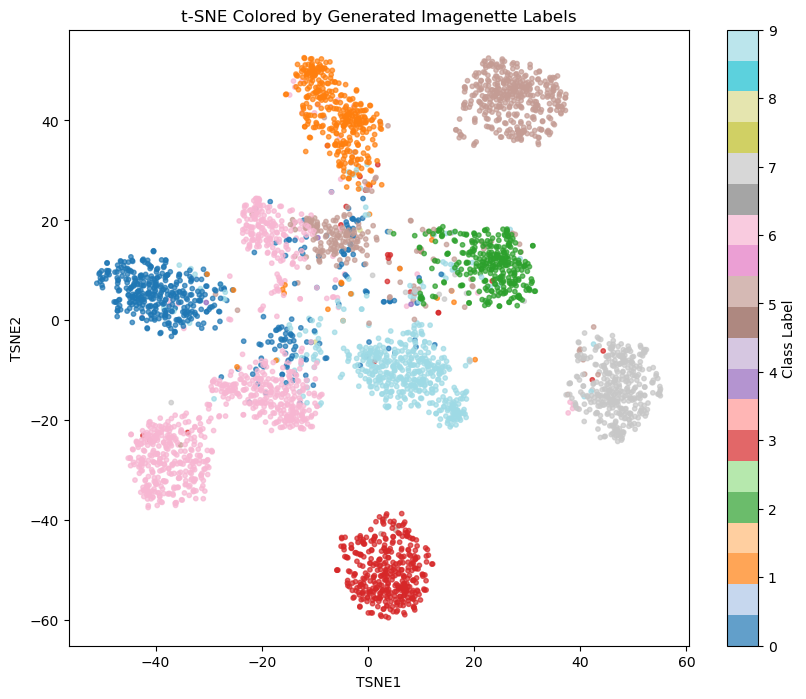

In [7]:
def centre_kernel(B):
    """
    Given low-rank factors  K ≈ B B^T,
    return factors of the centred kernel  K_c = H K H  (row/col sums = 0).
    """
    n, r = B.shape
    B_c  = B - B.mean(axis=0, keepdims=True)   # subtract column means
    return B_c

def lowrank_prefix_sampler_multiclass(B, T=1.0, q=5, seed=None):
    """
    Low-rank prefix sampler for the Potts / multi-class task-prior
        P(y) ∝ exp( β * Tr(Yᵀ K Y) ),   with  K ≈ B Bᵀ ,  β = 1/T.

    Parameters
    ----------
    B   : (n, r) ndarray       low-rank factor (e.g. Nyström or SVD) so K ≈ B Bᵀ
    T   : float                temperature (larger T ⇒ weaker couplings)
    q   : int                  number of classes (q = 5 by default)
    seed: int or None          random seed

    Returns
    -------
    labels : (n,) ndarray of ints in {0,…,q-1}
    """
    if seed is not None:
        np.random.seed(seed)

    n, r   = B.shape
    beta   = 1.0 / T
    labels = np.empty(n, dtype=np.int16)

    # running class-wise prefix sums   U[:, c] = Σ_{j<i, y_j=c} B[j]
    U = np.zeros((r, q), dtype=B.dtype)

    for i in range(n):
        # field for each class:   h_c = β · B[i]^T · U[:, c]
        h = beta * (B[i] @ U)        # shape (q,)

        # softmax to get conditional probabilities  P(y_i=c | prefix)
        h -= h.max()                 # numerical stabilisation
        p = np.exp(h)
        p /= p.sum()

        # sample the class
        c = np.random.choice(q, p=p)
        labels[i] = c

        # update the prefix accumulator for the chosen class
        U[:, c] += B[i]

    return labels

labels_final = lowrank_prefix_sampler_multiclass(centre_kernel(B), T=.1, q =10)

num_classes = labels_final.max() + 1
for c in range(num_classes):
    print(f"Fraction in class {c}:", (labels_final == c).mean())

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
            c=labels_final, cmap = "tab20", s=10, alpha=0.7)
plt.colorbar(label='Class Label')
plt.title("t-SNE Colored by Generated Imagenette Labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

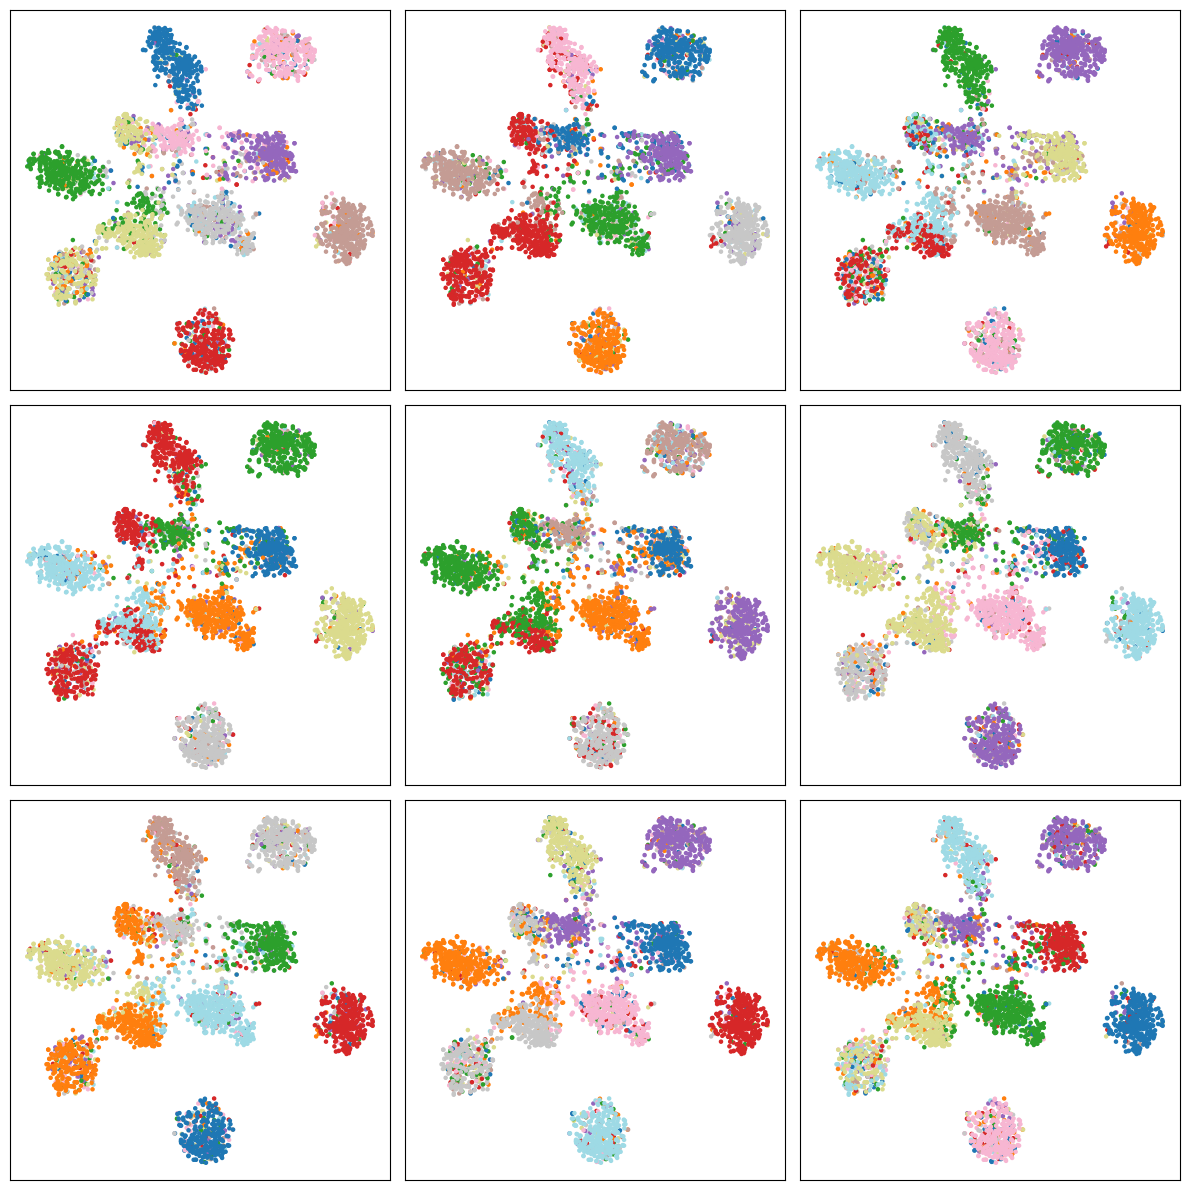

In [16]:
import math

n = 9      # number of runs
cols = 3    # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()
labels_list = []

for i in trange(n):
    # sample and plot
    labels_run = lowrank_prefix_sampler_multiclass(centre_kernel(normed_embeddings.cpu().numpy()), T=2.74, q=10, seed=i)

    labels_list.append(labels_run)
    ax = axes[i]
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
               c=labels_run, cmap="tab20", s=5, alpha=1)
    #ax.set_title(f"run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

# hide any extra axes
for ax in axes[n:]:
    ax.axis("off")

# Save the figure to a file
plt.savefig('imagenette_labelings_grid.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
import math

n = 256      # number of runs
labels_list = []

for i in trange(n):
    # sample and plot
    labels_run = lowrank_prefix_sampler_multiclass(centre_kernel(normed_embeddings.cpu().numpy()), T=10, q=2, seed=i)
    labels_list.append(labels_run)

  0%|          | 0/256 [00:00<?, ?it/s]

In [39]:
labels_list = np.array(labels_list)
labels_list.shape

np.save('labels_list_imagenette_1.npy', labels_list)